In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root
from scipy.linalg import eig
from scipy.interpolate import interp1d
import pywt
import os
from FREs import *


In [3]:
# config for plotting. copied from 修論
config = {
        'font.family' : 'sans-serif',
        'font.size' : 12.0,
        'xtick.direction' : 'in',
        'ytick.direction' : 'in',
        'axes.xmargin' : 0.1,
        'axes.ymargin' : 0.11,
        'axes.linewidth' : 1.0,
        'axes.titlelocation' : 'left',
        'lines.linewidth' : 0.7,
        'legend.fancybox' : False,
        'legend.loc' : 'upper right'
    }
plt.rcParams.update(config)
# label = ['(' + chr(ord("a")+i) + ')' for i in range(26)]
savedir = 'fig3/'
os.makedirs(savedir, exist_ok=True)

In [4]:
# parameters
J = 15; eta = -5; delta = 1.0
t0 = 0; t1 = 100
t_eval = np.linspace(t0, t1, 10000)
# compute fixed points
focus = root(lambda y : fre_single(0, y, J, eta, delta), [[1, 0]]).x
node = root(lambda y : fre_single(0, y, J, eta, delta), [[0, -2]]).x
saddle = root(lambda y : fre_single(0, y, J, eta, delta), [[0.5, -0.5]]).x


In [11]:
def simulate_pulse(amp_in, sigma_in,
                   tol=1e-3,      # node／focus に「十分近い」と判定する閾値
                   t_extra=100.0   # パルス窓外に確保する余裕時間
                   ):
    """
    • node に収束：従来通り amp_out, sigma_out を返す
    • focus に収束：np.nan, np.nan を返す
    • どちらにも十分近づかずに終了：np.nan, np.nan を返す
    • 数値的不安定（amp_in<0, sigma_in<0 など）も同様に nan
    """

    # --- 1. 不正入力は即座に nan ---
    if amp_in < 0.0 or sigma_in < 0.0:
        return np.nan, np.nan
    if amp_in >= 0.0 and amp_in < 1e-2:
        return 0.0, 0.0
    # --- 2. node / focus へ近づいたら積分を打ち切るイベントを定義 ---
    def event_node(t, y, *args):
        return np.linalg.norm(y - node) - tol
    event_node.terminal = True
    event_node.direction = -1                # 距離が減少して 0 を横切ったとき

    def event_focus(t, y, *args):
        return np.linalg.norm(y - focus) - tol
    event_focus.terminal = True
    event_focus.direction = -1

    # --- 3. delta パルス近似かガウスパルスかで条件分岐 ---
    if sigma_in < 1e-3:
        # --- delta パルス近似 ---
        t0, t1 = 0.0, t_extra
        t_eval = np.linspace(t0, t1, 10000)
        sol = solve_ivp(
            fre_single, (t0, t1), node + np.array([0, amp_in]),
            args=(J, eta, delta),
            events=[event_node, event_focus],
            t_eval=t_eval
        )
    else:
        # --- ガウスパルス ---
        t0 = -5.0 * sigma_in
        t1 =  5.0 * sigma_in + t_extra

        i_ext = lambda t: amp_in * np.exp(-0.5 * (t / sigma_in) ** 2) / (
            np.sqrt(2.0 * np.pi) * sigma_in
        )

        sol = solve_ivp(
            fre_single, (t0, t1), node,
            args=(J, eta, delta, i_ext),
            rtol=1e-10, atol=1e-10, method = 'RK45',
            events=[event_node, event_focus],
        )

    # --- 4. 収束先を判定 ---
    hit_node  = sol.t_events[0].size > 0
    hit_focus = sol.t_events[1].size > 0

    # 積分が通常終了した場合は終端点をチェック
    if not (hit_node or hit_focus):
        if np.linalg.norm(sol.y[:, -1] - node)  < tol:
            hit_node = True
        elif np.linalg.norm(sol.y[:, -1] - focus) < tol:
            hit_focus = True

    # focus 収束 or 未収束 → nan
    if hit_focus or not hit_node:
        return np.nan, np.nan

    # --- 5. node 収束時は従来通り amp_out / sigma_out を計算 ---
    baseline = node[0]
    y = sol.y[0] - baseline
    mask = y > 0.0
    if not mask.any():                       # ゼロ応答
        return 0, 0

    amp_out = np.trapz(y[mask], sol.t[mask]) * J
    t0_out  = np.trapz(sol.t[mask] * y[mask], sol.t[mask]) / amp_out
    var     = np.trapz(((sol.t[mask] - t0_out) ** 2) * y[mask],
                       sol.t[mask]) / amp_out
    sigma_out = np.sqrt(var)
    amp_out = float(amp_out)
    sigma_out = float(sigma_out)
    return amp_out, sigma_out


amp_in, sigma_in = 4.2, 0.1
amp_out, sigma_out = (20.39257849400832, 0.25352744869511346)


/tmp/ipykernel_1564616/783715077.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


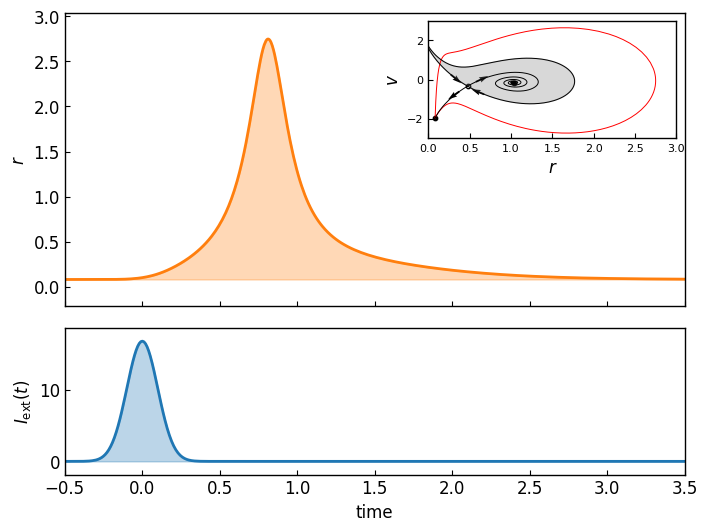

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# trajectory of spike
amp_in = 4.2
sigma_in = 0.1
print(f"amp_in, sigma_in = {amp_in}, {sigma_in}")
print(f"amp_out, sigma_out = {simulate_pulse(amp_in, sigma_in)}")

# --- ガウスパルス ---
t0_spike = -5.0 * sigma_in
t1_spike =  5.0 * sigma_in + 3.0

i_ext = lambda t: amp_in * np.exp(-0.5 * (t / sigma_in) ** 2) / (
    np.sqrt(2.0 * np.pi) * sigma_in
)

sol_spike = solve_ivp(
    fre_single, (t0_spike, t1_spike), node,
    args=(J, eta, delta, i_ext),
    rtol=1e-7, atol=1e-10, method='LSODA',
)

amp_out, sigma_out = simulate_pulse(amp_in, sigma_in)
# sol_spike.t, sol_spike.y の代わりに例データを仮置き
t = sol_spike.t
r = sol_spike.y[0]
i_ext_vals = i_ext(sol_spike.t)
# 平均応答時刻 t0_out の計算（既存コードと同じ）
mask = r > 0
t0_out = np.trapz(t[mask] * r[mask], t[mask]) / np.trapz(r[mask], t[mask])

fig = plt.figure(figsize=(8, 6))
gs = GridSpec(2, 1, height_ratios=[2, 1], hspace=0.1)

# ── 上段：r(t) プロット ──
ax_r = fig.add_subplot(gs[0])
ax_r.plot(t, r, linewidth=2, color='C1')
ax_r.fill_between(t, r, r[0], where=(r>r[0]), color='C1', alpha=0.3)
ax_r.set_ylabel(r'$r$')
ax_r.set_xlim(t0_spike, t1_spike)
plt.setp(ax_r.get_xticklabels(), visible=False)


# ── 下段：i_ext(t) プロット ──
ax_ie = fig.add_subplot(gs[1], sharex=ax_r)
ax_ie.plot(t, i_ext_vals, linewidth=2, color='C0')
ax_ie.fill_between(t, i_ext_vals, 0, where=(i_ext_vals>0), color='C0', alpha=0.3)
ax_ie.set_ylabel(r'$I_{\mathrm{ext}}(t)$')
ax_ie.set_xlabel('time')


# phase‐plane インセット
ax_ins = inset_axes(ax_r, width="40%", height="40%", loc='upper right')
ax_ins.plot(sol_spike.y[0], sol_spike.y[1], c='r')
ax_ins.scatter(*focus, c = 'k', label = 'focus', s = 10)
ax_ins.scatter(*node, c = 'k', label = 'node', s = 10)
ax_ins.scatter(*saddle, c = 'w', edgecolor = 'k', label = 'saddle', s = 10)

w, v = eig(fre_single_jacobian(0, saddle, J, eta, delta))
v_m = v[:, w<0].flatten() # eigenvalue < 0
v_p = v[:, w>0].flatten() # eigenvalue > 0
t0 = 0; t1 = 100
t_eval = np.linspace(t0, t1, 10000)
sol1 = solve_ivp(fre_single, (t0, t1), saddle + v_p * 1e-5, args = (J, eta, delta), t_eval=t_eval)
sol2 = solve_ivp(fre_single, (t0, t1), saddle - v_p * 1e-5, args = (J, eta, delta), t_eval=t_eval)
sol3 = solve_ivp(fre_single_inverse, (t0, t1), saddle + v_m * 1e-5, args = (J, eta, delta), t_eval=t_eval)
sol4 = solve_ivp(fre_single_inverse, (t0, t1), saddle - v_m * 1e-5, args = (J, eta, delta), t_eval=t_eval)

for i, sol in enumerate([sol1, sol2, sol3, sol4]):
    ax_ins.plot(sol.y[0], sol.y[1], c = 'k')
    if i <= 1:
        idx = np.argmax(np.abs(sol.y[0] - saddle[0]) > 0.1)
    else:
        idx = np.argmax(np.abs(sol.y[0] - saddle[0]) > 0.2)
    r, v = sol.y[:, idx]
    dr, dv = fre_single(sol.t[idx], [r, v], J, eta, delta)
    ax_ins.quiver(r, v, dr, dv, angles = 'xy')
# fill basin of attraction
r_fill = np.append(sol3.y[0], sol4.y[0][::-1]) # XXX : なんで[::-1]が必要なのかは十分に理解しているわけではない...
v_fill = np.append(sol3.y[1], sol4.y[1][::-1])
ax_ins.fill(r_fill, v_fill, alpha = 0.3, c = 'gray')

ax_ins.set_xlabel(r'$r$')
ax_ins.set_ylabel(r'$v$')
ax_ins.set_xlim(0, 3)
ax_ins.set_ylim(-3, 3)
ax_ins.tick_params(labelsize=8)
plt.tight_layout()
plt.savefig(savedir + 'spike_dynamics.pdf', bbox_inches='tight')
plt.show()


In [13]:
"""
amp–sigma 平面の吸引領域を描くユーティリティ
-------------------------------------------------
* `simulate_pulse(amp, sigma)` は既存実装をインポートして使う
* Python 3.9 以上推奨
"""
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool, cpu_count
from functools import partial
from collections import defaultdict

# ------------------------------- 設定 -------------------------------
AMP_MIN, AMP_MAX, N_AMP   = 0.0, 30.0, 200   # amp グリッド
SIG_MIN, SIG_MAX, N_SIGMA = 0.0,  1.5, 200   # sigma グリッド
MAX_ITER   = 100           # 1 点あたりの最大反復回数
TOL        = 1e-3         # 収束判定幅
ROUND_DIG  = 1            # 固定点同定用に丸める桁数
N_WORKERS  = max(1, cpu_count() - 1)

# # ------------------ ① キャッシュ付き反復 ------------------
# def iterate_point_cached(amp0, sig0,
#                          max_iter=MAX_ITER, tol=TOL,
#                          _local_cache=defaultdict(lambda:-999)):
#     """
#     _local_cache はスレッドローカル辞書:
#       key = (round(amp,RD), round(sig,RD)) → label
#       -999 は「未計算」を示す sentinel
#     """
#     path_keys = []                         # 経路を溜めて最後に書き込む
#     amp, sig  = amp0, sig0

#     for _ in range(max_iter):
#         key = (round(amp, ROUND_DIG), round(sig, ROUND_DIG))
#         cached = _local_cache[key]
#         if cached != -999:                 # キャッシュヒット
#             label = cached
#             break

#         amp_nxt, sig_nxt = simulate_pulse(amp, sig)

#         # NaN → -1, 未収束 → -2
#         if np.isnan(amp_nxt) or np.isnan(sig_nxt):
#             label = -1;  path_keys.append(key);  break

#         if abs(amp_nxt-amp) < tol and abs(sig_nxt-sig) < tol:
#             label = key                      # 固定点そのものを key に
#             path_keys.append(key);  break

#         path_keys.append(key)
#         amp, sig = amp_nxt, sig_nxt
#     else:
#         label = -2                           # 反復オーバー

#     # 経路の全点を同じラベルで登録
#     for k in path_keys:
#         _local_cache[k] = label
#     return label
# -------------------- 1. 1 点を評価する関数 -------------------------
def iterate_point(amp0: float, sig0: float,
                  max_iter: int = MAX_ITER,
                  tol: float = TOL):
    amp, sig = amp0, sig0
    for _ in range(max_iter):
        amp_nxt, sig_nxt = simulate_pulse(amp, sig)

        # NaN 域 = -1 ラベルで返す
        if np.isnan(amp_nxt) or np.isnan(sig_nxt):
            return -1

        # 収束判定
        if abs(amp_nxt - amp) < tol and abs(sig_nxt - sig) < tol:
            # 固定点は丸めてハッシュ化
            key = (round(amp_nxt, ROUND_DIG), round(sig_nxt, ROUND_DIG))
            return key

        amp, sig = amp_nxt, sig_nxt

    # 発散／未収束 = -2
    return -2

# ---------------- 2. グリッド全体を並列で評価 ----------------------
amp_grid   = np.linspace(AMP_MIN, AMP_MAX, N_AMP, dtype=np.float32)
sig_grid   = np.linspace(SIG_MIN, SIG_MAX, N_SIGMA, dtype=np.float32)
A, S       = np.meshgrid(amp_grid, sig_grid, indexing="ij")

# 1 セルずつ渡すためフラット化
points_flat = list(zip(A.ravel(), S.ravel()))
# with mp.Pool(N_WORKERS) as pool:
#     # chunksize を 256 程度にすると小タスク分割回数が大幅減
#     labels_flat = pool.starmap(iterate_point_cached,
#                                points_flat,
#                                chunksize=256)

# labels_obj = np.array(labels_flat, dtype=object).reshape(A.shape)
with Pool(N_WORKERS) as pool:
    labels_flat = pool.starmap(iterate_point, points_flat)

labels = np.array(labels_flat, dtype=object).reshape(A.shape)

# ---------------- 3. 固定点ラベルを整数に変換 ----------------------
unique_keys = {k: i for i, k in
               enumerate(sorted({lab for lab in labels_flat if isinstance(lab, tuple)}))}

def to_int_label(x):
    if x == -1: return -1    # NaN 域
    if x == -2: return -2    # 未収束／発散
    return unique_keys[x]    # 0,1,2,… で固定点をインデックス化

int_labels = np.vectorize(to_int_label, otypes=[int])(labels)
# int_labels = np.vectorize(to_int_label, otypes=[int])(labels_obj)

# ---------------- 5. 収束先の座標一覧を出力 -------------------------
print("Identified fixed points (rounded):")
for k, idx in unique_keys.items():
    print(f"  ID {idx:2d}: amp = {k[0]:.3f}, sigma = {k[1]:.3f}")
print("  -1 : NaN basin")
print("  -2 : Divergent / no convergence")


Identified fixed points (rounded):
  ID  0: amp = 0.000, sigma = 0.000
  ID  1: amp = 14.700, sigma = 0.000
  -1 : NaN basin
  -2 : Divergent / no convergence


In [78]:
# ==============================================================
# 9. ベクトル場 (flow field) を重ね描き
#    ── simulate_pulse(amp, sigma) を1ステップだけ適用して
#       Δamp, Δsigma を矢印で可視化
# ==============================================================

# ── coarse グリッド上の (amp, sigma) 点を用意（既出）
amp_grid_coarse = np.linspace(AMP_MIN, AMP_MAX, 10)
sig_grid_coarse = np.linspace(SIG_MIN, SIG_MAX, 10)
A_coarse, S_coarse = np.meshgrid(amp_grid_coarse, sig_grid_coarse, indexing="ij")

# ── Δamp, Δsigma を計算
U = np.zeros_like(A_coarse)   # Δamp
V = np.zeros_like(S_coarse)   # Δsigma
valid = np.ones_like(A_coarse, dtype=bool)

for i in range(A_coarse.shape[0]):
    for j in range(A_coarse.shape[1]):
        amp, sig = A_coarse[i, j], S_coarse[i, j]
        amp_nxt, sig_nxt = simulate_pulse(amp, sig)

        if np.isnan(amp_nxt) or np.isnan(sig_nxt):
            valid[i, j] = False          # NaN 域は矢印を描かない
        else:
            U[i, j] = amp_nxt - amp
            V[i, j] = sig_nxt - sig

In [79]:
# ---------------------------------------------------------------------
# 6.  1 つの (amp,sigma) から軌跡を返す関数
# ---------------------------------------------------------------------
def get_trajectory(amp0, sig0, max_iter=MAX_ITER, tol=TOL*10):
    """
        simulate_pulse を反復し，(amp,sigma) のリストを返す.
        描画用なので, tolは大きめの判定で大丈夫.
    """
    traj = [(amp0, sig0)]
    amp, sig = amp0, sig0
    for _ in range(max_iter):
        amp_nxt, sig_nxt = simulate_pulse(amp, sig)

        # NaN や未収束なら打ち切り
        if np.isnan(amp_nxt) or np.isnan(sig_nxt):
            traj.append((amp_nxt, sig_nxt))
            break

        traj.append((amp_nxt, sig_nxt))

        if abs(amp_nxt - amp) < tol and abs(sig_nxt - sig) < tol:
            break
        amp, sig = amp_nxt, sig_nxt
    return np.array(traj)      # shape = (T, 2)

0.0 0.0
14.685939167084863 0.022921165311113195


/tmp/ipykernel_1564616/4088951297.py:147: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize='small', frameon=False)


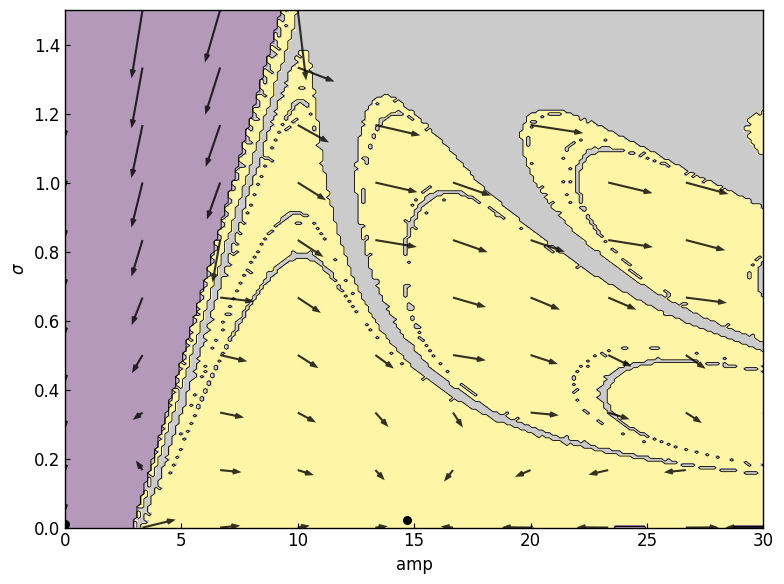

In [82]:
# ---------------- 4. プロット ----------------------
fig, ax = plt.subplots(figsize=(8, 6))

from matplotlib.colors import ListedColormap, BoundaryNorm

# ――― カラーマップ & ノーマライザ ――――――――――――――――――――――――
n_fix        = len(unique_keys)               # 固定点の個数
colors_fixed = plt.cm.viridis(np.linspace(0, 1, n_fix))

# ❶ ラベル昇順に   [-2, -1, 0, 1, …]  を並べる
cmap = ListedColormap(np.vstack([
        [[1, 1, 1, 1]],        # -2  Divergent  ➜ 白
        [[0.5, 0.5, 0.5, 1]],  # -1  NaN        ➜ 灰
        colors_fixed           #  0… 固定点     ➜ 色
]))

# ❷ 半整数境界  …,-2.5,-1.5,-0.5,0.5,…,n_fix-0.5
bounds = np.arange(-2.5, n_fix - 0.5 + 1, 1)   # stop は含まれないので +1
norm   = BoundaryNorm(bounds, cmap.N)

# ――― ベイスン図 ―――――――――――――――――――――――――――――――――――――
im = ax.imshow(int_labels.T, origin="lower",
               extent=[AMP_MIN, AMP_MAX, SIG_MIN, SIG_MAX],
               cmap=cmap, norm=norm, interpolation="nearest",
               aspect="auto", alpha=0.4)

# ――― 境界線（等高線）―――――――――――――――――――――――――――――
# levels = [-1.5, -0.5] + np.arange(0.5, n_fix - 0.5, 1)
# levels = [-1.5, -0.5]

ax.contour(A, S, int_labels == 0, levels=[0.5], colors="k", linewidths=0.6, linestyles="solid")
ax.contour(A, S, int_labels == 1, levels=[0.5], colors="k", linewidths=0.6, linestyles="solid")

# ――― カラーバー ――――――――――――――――――――――――――――――――
# ticks = np.arange(-2, n_fix, 1)                # [-2, -1, 0, 1, …]
# cbar  = fig.colorbar(im, ax=ax, boundaries=bounds, ticks=ticks)

# tick_labels = (["Div", "NaN"] +                # -2, -1
#                [f"ID {idx}: ({fp[0]:.2f},{fp[1]:.2f})"
#                 for (fp, idx) in unique_keys.items()])
# cbar.ax.set_yticklabels(tick_labels)
# cbar.ax.set_title("ID", pad=8)



# # ---------------------------------------------------------------------
# # 7-A. 代表点を「手動で」指定して描く
# # ---------------------------------------------------------------------
# start_points = [
#     (2.5, 1.4),
#     (6.0, 1.4),
#     (6.0, 0.1),
#     (10.0, 0.60),
#     (29.5, 0.1),
# ]
# for sp in start_points:
#     traj = get_trajectory(*sp)

#     # ── NaN が出たら “最初の NaN 以前” だけ抽出 ──────────────
#     nan_idx    = np.where(np.isnan(traj[:, 0]))[0]
#     end_idx    = nan_idx[0] if nan_idx.size else len(traj)
#     traj_valid = traj[:end_idx]                 # NaN の直前まで

#     # ── 矢印で描画（各ステップごとにベクトル） ─────────────────
#     x,  y  = traj_valid[:-1, 0], traj_valid[:-1, 1]     # 始点
#     dx, dy = np.diff(traj_valid[:, 0]), np.diff(traj_valid[:, 1])

#     ax.quiver(x, y, dx, dy,
#               angles='xy', scale_units='xy', scale=1,      # データ座標ベース
#               width=0.003, headwidth=5, headlength=5,
#               color='k')                                   # 矢印本体

#     # 始点と終点だけ目印を付ける（任意）
#     ax.scatter(sp[0], sp[1],   s=30,  marker='o', facecolor='none', edgecolor='k')
#     ax.scatter(traj_valid[-1,0], traj_valid[-1,1],
#                s=40, marker='s', facecolor='k',  edgecolor='k')

# ベクトル場の描画
# 3) ---- 振幅を「非線形スケーリング」で圧縮 -----------------
#   mag →   0 … max   を   0 … 1   に正規化
#   さらに γ(0<γ<1) 乗する事でダイナミックレンジを圧縮
mag   = np.hypot(U, V)
mag_max = mag[valid].max()
gamma = 0.5                       # γ=0   : 全矢印が同じ長さ
                                   # γ=1   : 元の長さそのまま
mag_scaled = np.zeros_like(mag)
mag_scaled[valid] = (mag[valid] / mag_max) ** gamma

# U, V をスケーリング
eps = 1e-12
U_scaled = np.where(valid, U / (mag + eps) * mag_scaled, 0)
V_scaled = np.where(valid, V / (mag + eps) * mag_scaled, 0)

# norms = np.hypot(U, V).max()
# if norm > 0:
#     U, V = U / norm, V / norm            # 最大ベクトルを “1” にそろえる

ax.quiver(A_coarse[valid], S_coarse[valid],
          U_scaled[valid], V_scaled[valid],
          angles='xy', scale_units='xy', scale=None,  # scale=0.15 は矢印を少し伸ばす係数
          color='k', width=0.003, headwidth=3, headlength=4, alpha=0.8)


# 固定点の描画
def iterate_point_raw(amp0: float, sig0: float,
                  max_iter: int = MAX_ITER,
                  tol: float = TOL):
    amp, sig = amp0, sig0
    for _ in range(max_iter):
        amp_nxt, sig_nxt = simulate_pulse(amp, sig)

        # NaN 域 = -1 ラベルで返す
        if np.isnan(amp_nxt) or np.isnan(sig_nxt):
            return -1

        # 収束判定
        if abs(amp_nxt - amp) < tol and abs(sig_nxt - sig) < tol:
            # 固定点は丸めてハッシュ化
            return  amp_nxt, sig_nxt

        amp, sig = amp_nxt, sig_nxt

    # 発散／未収束 = -2
    return -2
for k, idx in unique_keys.items():
        if idx == -1 or idx == -2:
                continue
        amp, sig = k
        amp_raw, sig_raw = iterate_point_raw(amp, sig)
        print(amp_raw, sig_raw)
        if np.isnan(amp_raw) or np.isnan(sig_raw):
            continue
        # ── 固定点を描画 ───────────────────────────────
        if amp_raw < 1e-2:
                amp_raw += 0.01 # 描画用
        if sig_raw < 1e-2:
                sig_raw += 0.01
        ax.scatter(amp_raw, sig_raw, s=30, marker='o', c = 'k')
# ---------------------------------------------------------------------
# 8.  レジェンド & 再描画
# ---------------------------------------------------------------------
# ――― 軸ラベルなど ―――――――――――――――――――――――――――――――
ax.set_xlabel("amp")
ax.set_ylabel(r"$\sigma$")
# ax.set_title("Basins of attraction in (amp, sigma) space")

ax.legend(loc='upper right', fontsize='small', frameon=False)
fig.canvas.draw()
plt.tight_layout()
plt.savefig(savedir + 'basin_of_attraction.pdf', bbox_inches='tight')
plt.show()



ここから下は使ってないコード（動かないものも含む）.

In [53]:
iterate_point(14.7, 0.0)

(14.7, 0.0)

In [32]:
# 例：amp ∈ [0.1, 10], σ ∈ [0.01, 5]
n_amp   = 51       # きめ細かさ（増やすと滑らか／計算は重く）
n_sigma = 51
amp_grid   = np.linspace(0.1, 30.0, n_amp)
sigma_grid = np.linspace(0.01, 2.0, n_sigma)

AMP, SIGMA = np.meshgrid(amp_grid, sigma_grid)   # shape = (n_sigma, n_amp)


In [33]:
amp_out   = np.empty_like(AMP)
sigma_out = np.empty_like(SIGMA)

for i in range(n_sigma):
    for j in range(n_amp):
        a_in  = AMP[i, j]
        s_in  = SIGMA[i, j]
        a_out, s_out = simulate_pulse(a_in, s_in)
        amp_out[i, j]   = a_out
        sigma_out[i, j] = s_out

# 差（1ステップでの変位ベクトル）
dA = amp_out   - AMP
dS = sigma_out - SIGMA


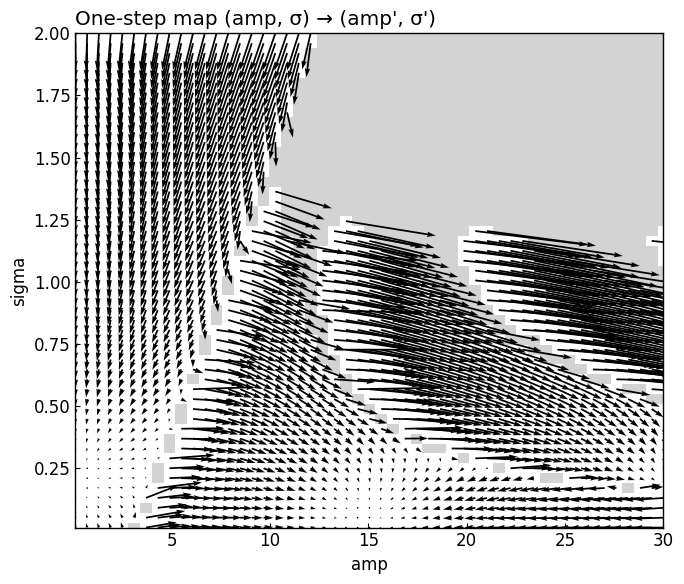

In [34]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(7, 6))
mask_nan = np.isnan(amp_out) | np.isnan(sigma_out)

# mask_nan : True なら発散領域
mask_plot = np.where(mask_nan, 1.0, np.nan)   # 非発散セルは NaN

cmap_nan = ListedColormap(['lightgray'])       # 1 色で OK
ax.pcolormesh(
    AMP, SIGMA, mask_plot,
    cmap=cmap_nan,
    shading='auto'
)
# ---- ベクトル場 ----
# 矢印が長過ぎる場合はスケールを調整
scale = 0.1
ax.quiver(
    AMP[~mask_nan], SIGMA[~mask_nan],
    dA [~mask_nan], dS   [~mask_nan],
    angles='xy', scale_units='xy', scale=1/scale, width=0.003
)

ax.set_xlabel('amp')
ax.set_ylabel('sigma')
ax.set_title('One-step map (amp, σ) → (amp\', σ\')')
ax.set_xlim(amp_grid[0], amp_grid[-1])
ax.set_ylim(sigma_grid[0], sigma_grid[-1])
# ax.set_aspect('equal')   # 正方パネルにして視覚バイアスを回避
plt.tight_layout()
plt.show()


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# ────────────────────────────────────────────────
# 1. パラメータ設定
# ────────────────────────────────────────────────
AMP_MIN, AMP_MAX   = 0.0, 20.0       # 描画範囲 (amp)
SIG_MIN, SIG_MAX   = 0.0, 1.0        # 描画範囲 (sigma)
N_AMP,  N_SIG      = 101, 101        # グリッド分割数
MAX_ITER           = 30             # 反復上限
EPS_CONV           = 1e-3            # 収束判定閾値

# 既知の固定点（推定値）  ─ 任意に追加可
ATTRACTORS = np.array([
    ( 0.0,  0.0),   # A: 原点近傍
    (15.0,  0.0),   # B: amp ≃ 15, sigma ≃ 0
], dtype=float)

# ────────────────────────────────────────────────
# 2. グリッド生成
# ────────────────────────────────────────────────
amp_grid   = np.linspace(AMP_MIN, AMP_MAX, N_AMP)
sig_grid   = np.linspace(SIG_MIN, SIG_MAX, N_SIG)
AMP0, SIG0 = np.meshgrid(amp_grid, sig_grid)        # shape = (N_SIG, N_AMP)

# 結果を格納する配列
#   0: attractor A, 1: attractor B, 2: divergence(nan), 3: 未分類/非収束
labels = np.full_like(AMP0, fill_value=3, dtype=np.int8)

# ────────────────────────────────────────────────
# 3. 反復して収束先を判定
# ────────────────────────────────────────────────
for i in range(N_SIG):
    for j in range(N_AMP):
        a, s = AMP0[i, j], SIG0[i, j]
        for _ in range(MAX_ITER):
            a_next, s_next = simulate_pulse(a, s)
            # 発散判定 (nan)
            if np.isnan(a_next) or np.isnan(s_next):
                labels[i, j] = 2
                break
            # 収束判定：既知 attractor との距離
            dist = np.hypot(ATTRACTORS[:,0] - a_next,
                            ATTRACTORS[:,1] - s_next)
            hit = np.where(dist < EPS_CONV)[0]
            if hit.size:
                labels[i, j] = int(hit[0])  # 最初に満たした attractor
                break
            # まだ収束していないなら次へ
            a, s = a_next, s_next

# ────────────────────────────────────────────────
# 4. 可視化
# ────────────────────────────────────────────────
cmap = ListedColormap([
    "#2460ff",   # 0: attractor A (青)
    "#ff6c24",   # 1: attractor B (橙)
    "#999999",   # 2: nan/divergence (灰)
    "#ffffff",   # 3: 未分類・非収束 (白)
])
fig, ax = plt.subplots(figsize=(7, 4))
im = ax.imshow(
    labels,
    origin="lower",
    extent=[AMP_MIN, AMP_MAX, SIG_MIN, SIG_MAX],
    aspect="auto",
    interpolation="nearest",
    cmap=cmap,
)
# 境界線を薄く描く（ラプラシアンで検出）
boundary = np.zeros_like(labels, dtype=bool)
boundary[1:-1,1:-1] = (
    (labels[1:-1,1:-1] != labels[:-2,1:-1]) |
    (labels[1:-1,1:-1] != labels[2:,1:-1])  |
    (labels[1:-1,1:-1] != labels[1:-1,:-2]) |
    (labels[1:-1,1:-1] != labels[1:-1,2:])
)
ax.contour(
    AMP0, SIG0, boundary.astype(int),
    levels=[0.5], colors="k", linewidths=0.4
)

# 軸ラベル・凡例
ax.set_xlabel("amp")
ax.set_ylabel("sigma")
ax.set_title("Basins of attraction in (amp, σ) plane")
handles = [
    plt.Line2D([0], [0], marker='s', color='none', markerfacecolor=c, markersize=8,
               label=lbl)
    for c, lbl in zip(cmap.colors,
        ["to (0,0)", "to (15,0)", "NaN/diverge", "unclassified"])
]
ax.legend(handles=handles, frameon=False, loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [28]:
from scipy.optimize import root
import numpy as np

def F_log(uv):
    u, v = uv
    a, s = np.exp(u), np.exp(v)           # 正領域に写像
    a_out, s_out = simulate_pulse(a, s)
    return np.array([np.log(a_out) - u,
                     np.log(s_out) - v])  # =0 が固定点条件

fixed_points = []
for a0 in amp_grid:
    for s0 in sigma_grid:
        sol = root(F_log, x0=[np.log(a0), np.log(s0)], method='hybr')
        if sol.success:
            a_fp, s_fp = np.exp(sol.x)    # 実空間に戻す
            if np.isfinite(a_fp) and np.isfinite(s_fp):
                if not any(np.hypot(a_fp-p[0], s_fp-p[1]) < 1e-3
                           for p in fixed_points):
                    fixed_points.append((a_fp, s_fp))


/home/genki/QIF-Network/venv/lib64/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =                  NaN   r2 =                  NaN


/home/genki/QIF-Network/venv/lib64/python3.12/site-packages/scipy/integrate/_ivp/lsoda.py:161: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  solver._y, solver.t = integrator.run(


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =                  NaN   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =                  NaN   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =                  NaN   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =                  NaN   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =                  NaN   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


KeyboardInterrupt: 

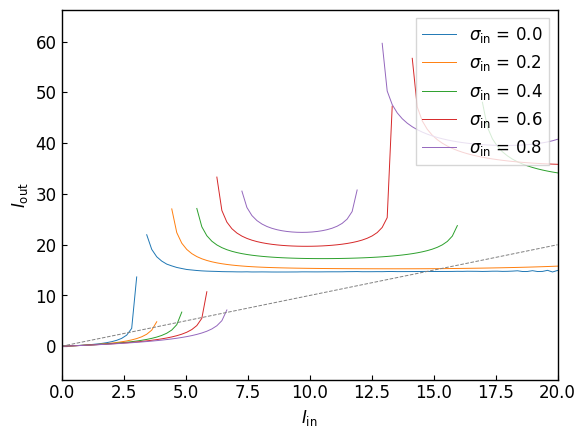

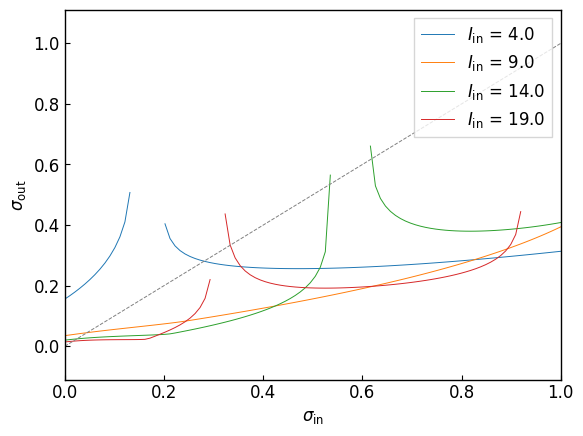

In [ ]:
amp_in_levels = np.arange(4, 20, 5.0)
amp_in_values = np.linspace(0, 20, 100)
sigma_in_levels = np.arange(0, 1.0, 0.2)
sigma_in_values = np.linspace(0, 1.0, 100)

for sigma_in in sigma_in_levels:
    amp_out = np.zeros_like(amp_in_values)
    for i, amp_in in enumerate(amp_in_values):
        amp_out[i], _ = simulate_pulse(amp_in, sigma_in)
    plt.plot(amp_in_values, amp_out, label=rf'$\sigma_{{\mathrm{{in}}}}$ = {sigma_in:.1f}')
plt.plot(amp_in_values, amp_in_values, linestyle='--', color='gray')
plt.xlabel(r'$I_{\mathrm{in}}$')
plt.ylabel(r'$I_{\mathrm{out}}$')
plt.xlim(amp_in_values[0], amp_in_values[-1])
plt.legend()
plt.show()


for amp_in in amp_in_levels:
    sigma_out = np.zeros_like(sigma_in_values)
    for i, sigma_in in enumerate(sigma_in_values):
        _, sigma_out[i] = simulate_pulse(amp_in, sigma_in)
    plt.plot(sigma_in_values, sigma_out, label=rf'$I_{{\mathrm{{in}}}}$ = {amp_in:.1f}')
plt.plot(sigma_in_values, sigma_in_values, linestyle='--', color='gray')
plt.xlabel(r'$\sigma_{\mathrm{in}}$')
plt.ylabel(r'$\sigma_{\mathrm{out}}$')
plt.xlim(sigma_in_values[0], sigma_in_values[-1])
plt.legend()
plt.show()

In [25]:
from scipy.optimize import root

def F(vec):
    a_in, s_in = vec
    a_out, s_out = simulate_pulse(a_in, s_in)
    return np.array([a_out - a_in, s_out - s_in])

fixed_points = []
# グリッド上の点を初期推定にしてローカル固定点探索
for a0 in amp_grid:
    for s0 in sigma_grid:
        sol = root(F, x0=[a0, s0], method='hybr')
        if sol.success and not np.isnan(sol.x).any():
            a_fp, s_fp = sol.x
            # すでに登録済みか確認（近傍判定）
            if not any(np.hypot(a_fp - p[0], s_fp - p[1]) < 1e-3 for p in fixed_points):
                fixed_points.append((a_fp, s_fp))

# 描画
for a_fp, s_fp in fixed_points:
    ax.plot(a_fp, s_fp, 'ro', markersize=6, label='fixed point')
if fixed_points:
    ax.legend(loc='upper right')


/home/genki/QIF-Network/venv/lib64/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


AssertionError: amp_in must be positive

In [ ]:


# ──────────────────────────────────────────────────────────────
# 1) sigma_in を固定して amp_in を連続掃引 → amp_out を観測
# ──────────────────────────────────────────────────────────────
sigma_fixed_levels = [0.01, 0.05, 0.10, 0.50, 1.0]  # 曲線ごとに固定する σ_in
amp_scan = np.linspace(3.0, 20.0, 100)              # 連続的に掃引する amp_in

plt.figure()
for sigma_in_val in sigma_fixed_levels:
    amp_out_vals = []
    for amp_in_val in amp_scan:
        amp_out_val, _ = simulate_pulse(amp_in_val, sigma_in_val)
        amp_out_vals.append(amp_out_val)
    plt.plot(amp_scan, amp_out_vals, label=f"sigma_in={sigma_in_val}")
plt.plot(amp_scan, amp_scan, ls="--", color="gray")  # 1:1 線
plt.xlabel("amp_in  (入力パルス面積)")
plt.ylabel("amp_out (出力パルス面積)")
plt.title("amp_out vs. amp_in  —  sigma_in を固定して amp_in を連続掃引")
plt.grid(True)
plt.legend()
plt.tight_layout()


# ──────────────────────────────────────────────────────────────
# 2) amp_in を固定して sigma_in を連続掃引 → sigma_out を観測
# ──────────────────────────────────────────────────────────────
amp_fixed_levels   = [3, 5, 7, 10, 15, 20]          # 曲線ごとに固定する amp_in
sigma_scan = np.logspace(np.log10(0.01), np.log10(1.0), 100)  # 連続的に掃引

plt.figure()
for amp_in_val in amp_fixed_levels:
    sigma_out_vals = []
    for sigma_in_val in sigma_scan:
        _, sigma_out_val = simulate_pulse(amp_in_val, sigma_in_val)
        sigma_out_vals.append(sigma_out_val)
    plt.plot(sigma_scan, sigma_out_vals, label=f"amp_in={amp_in_val}")
plt.plot(sigma_scan, sigma_scan, ls="--", color="gray")  # 1:1 線
plt.xscale("log")        # 幅のレンジが広いので対数軸が見やすい
plt.yscale("log")        
plt.xlabel("sigma_in (入力パルス幅)")
plt.ylabel("sigma_out (出力パルス幅)")
plt.title("sigma_out vs. sigma_in  —  amp_in を固定して sigma_in を連続掃引")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()

plt.show()


(2, 10000)
3.043555881986769 3.2433848220939674


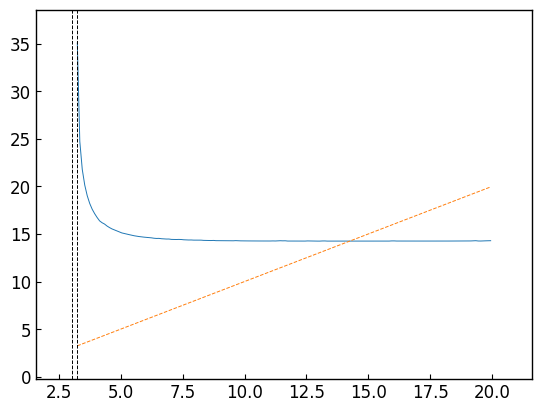

3.2433848220939674


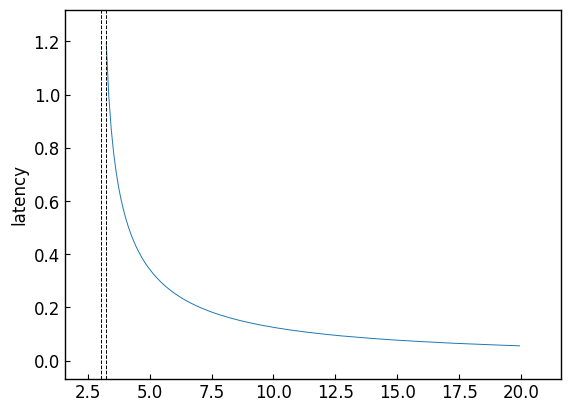

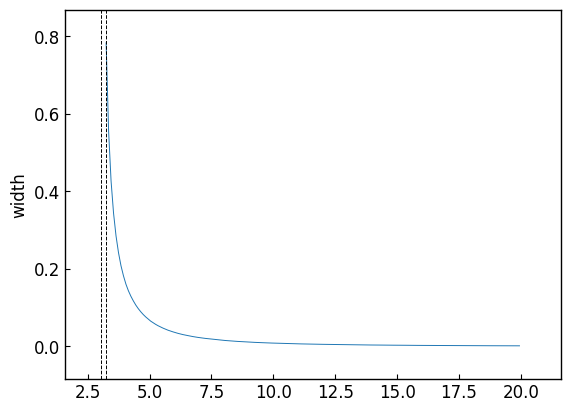

In [6]:
print(sol3.y.shape)
# th1: sol3.y[:, 0] (rの時系列) がnode[0] より小さくなる初めての時刻でのv
# th2: sol4.y[:, 0] (rの時系列) がnode[0] より小さくなる初めての時刻でのv
th1 = sol3.y[1, np.argmax(sol3.y[0,:] < node[0])] - node[1]
th2 = sol4.y[1, np.argmax(sol4.y[0,:] < node[0])] - node[1]

print(th1, th2)
# dv_arr = np.arange(1, J + 5, 0.1)
dv_arr = np.arange(th2, J + 5, 0.1)
# sol_arr = [None] * len(dv_arr)
latency_arr = [None] * len(dv_arr)
width_arr = [None] * len(dv_arr)
dv_next_arr = np.zeros_like(dv_arr)
for i, dv in enumerate(dv_arr):
    sol = solve_ivp(fre_single, (t0, t1), node + np.array([0, dv]), args = (J, eta, delta), t_eval=t_eval)
    # sol_arr[i] = sol
    latency_arr[i] = sol.t[np.argmax(sol.y[0])]
    r_max = np.max(sol.y[0])
    width_arr[i] = np.sum(sol.y[0] > (r_max - sol.y[0, 0]) / 2) * (t_eval[1] - t_eval[0])
    dv_next_arr[i] = J * (np.sum(sol.y[0]) - sol.y[0, 0] * len(sol.t)) * (t_eval[1] - t_eval[0])

plt.plot(dv_arr, dv_next_arr)
plt.plot(dv_arr, dv_arr, ls = '--')
plt.axvline(x = th1, color = 'k', ls = '--', label = 'th1')
plt.axvline(x = th2, color = 'k', ls = '--', label = 'th2')
plt.show();
print(dv_arr[np.argmax(dv_next_arr)])

plt.plot(dv_arr, latency_arr)
plt.ylabel('latency')
plt.axvline(x = th1, color = 'k', ls = '--', label = 'th1')
plt.axvline(x = th2, color = 'k', ls = '--', label = 'th2')

plt.show()

plt.plot(dv_arr, width_arr)
plt.ylabel('width')
plt.axvline(x = th1, color = 'k', ls = '--', label = 'th1')
plt.axvline(x = th2, color = 'k', ls = '--', label = 'th2')

plt.show()


latency   : 0.082352 [s]
amp_out   : 14.704196 (≒ 出力パルス面積)
sigma_out : 0.028244 [s]


/var/folders/dh/_by7m7p57ml0cv9c25qxfcc80000gn/T/ipykernel_30576/2182403387.py:61: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  amp_out = np.trapz(y[mask], sol5.t[mask])  * J                  # 面積（Hartree 単位 A と同義）
/var/folders/dh/_by7m7p57ml0cv9c25qxfcc80000gn/T/ipykernel_30576/2182403387.py:62: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  t0_out  = np.trapz(sol5.t[mask] * y[mask], sol5.t[mask]) / amp_out  # 重心
/var/folders/dh/_by7m7p57ml0cv9c25qxfcc80000gn/T/ipykernel_30576/2182403387.py:63: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  var     = np.trapz(((sol5.t[mask] - t0_out) ** 2) * y[mask],


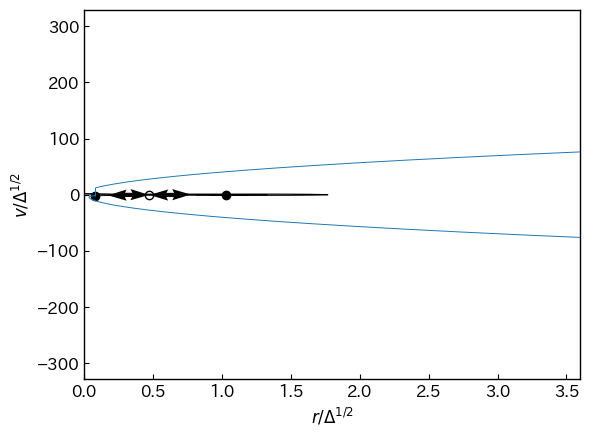

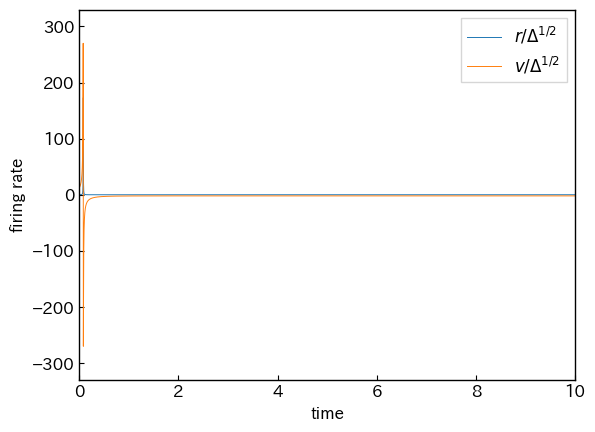

In [39]:
# parameters
J = 15; eta = -5; delta = 1.0
t0 =0; t1 = 100
t_eval = np.linspace(t0, t1, 10000)
# compute fixed points
focus = root(lambda y : fre_single(0, y, J, eta, delta), [[1, 0]]).x
node = root(lambda y : fre_single(0, y, J, eta, delta), [[0, -2]]).x
saddle = root(lambda y : fre_single(0, y, J, eta, delta), [[0.5, -0.5]]).x

plt.scatter(*focus, c = 'k', label = 'focus')
plt.scatter(*node, c = 'k', label = 'node')
plt.scatter(*saddle, c = 'w', edgecolor = 'k', label = 'saddle')

w, v = eig(fre_single_jacobian(0, saddle, J, eta, delta))
v_m = v[:, w<0].flatten() # eigenvalue < 0
v_p = v[:, w>0].flatten() # eigenvalue > 0
sol1 = solve_ivp(fre_single, (t0, t1), saddle + v_p * 1e-5, args = (J, eta, delta), t_eval=t_eval)
sol2 = solve_ivp(fre_single, (t0, t1), saddle - v_p * 1e-5, args = (J, eta, delta), t_eval=t_eval)
sol3 = solve_ivp(fre_single_inverse, (t0, t1), saddle + v_m * 1e-5, args = (J, eta, delta), t_eval=t_eval)
sol4 = solve_ivp(fre_single_inverse, (t0, t1), saddle - v_m * 1e-5, args = (J, eta, delta), t_eval=t_eval)

for i, sol in enumerate([sol1, sol2, sol3, sol4]):
    plt.plot(sol.y[0], sol.y[1], c = 'k')
    if i <= 1:
        idx = np.argmax(np.abs(sol.y[0] - saddle[0]) > 0.1)
    else:
        idx = np.argmax(np.abs(sol.y[0] - saddle[0]) > 0.2)
    r, v = sol.y[:, idx]
    dr, dv = fre_single(sol.t[idx], [r, v], J, eta, delta)
    plt.quiver(r, v, dr, dv, angles = 'xy')
# fill basin of attraction
r = np.append(sol3.y[0], sol4.y[0][::-1]) # XXX : なんで[::-1]が必要なのかは十分に理解しているわけではない...
v = np.append(sol3.y[1], sol4.y[1][::-1])
plt.fill(r, v, alpha = 0.3, c = 'gray')

# trajectory of spike
# NOTE: reset t0, t1 (bad practice...)
# t0 = 0; t1 = 5; t_eval = np.arange(t0, t1, 0.0001)

amp_in = 20.0
sigma_in = 0.0001
t0 = -sigma_in * 5
t1 = sigma_in * 5 + 10

i_ext = lambda t: amp_in * np.exp(-(t / sigma_in) ** 2) / (np.sqrt(2 * np.pi) * sigma_in)

sol5 = solve_ivp(fre_single, (t0, t1), node, args = (J, eta, delta, i_ext), rtol = 1e-15, atol = 1e-15)

# レイテンシ（ピーク位置）
latency = sol5.t[np.argmax(sol5.y[0])]

# ── 1. ベースラインを推定して差し引く ─────────────────────────────
#   • 入力前（t < 0）の平均値をベースラインとする
baseline = node[0]
y        = sol5.y[0] - baseline           # ベースライン補正済み応答

# ── 2. ガウシアンに寄与する部分（正の部分）をマスク ──────────────
mask = y > 0                              # 雑音が大きい場合は閾値を上げてもOK

# ── 3. モーメント法で面積 (= amp_out) と sigma を計算 ────────────────
amp_out = np.trapz(y[mask], sol5.t[mask])  * J                  # 面積（Hartree 単位 A と同義）
t0_out  = np.trapz(sol5.t[mask] * y[mask], sol5.t[mask]) / amp_out  # 重心
var     = np.trapz(((sol5.t[mask] - t0_out) ** 2) * y[mask], 
                   sol5.t[mask]) / amp_out
sigma_out = np.sqrt(2 * var)                                 # 本定義での sigma

print(f"latency   : {latency:.6f} [s]")
print(f"amp_out   : {amp_out:.6f} (≒ 出力パルス面積)")
print(f"sigma_out : {sigma_out:.6f} [s]")


plt.plot(sol5.y[0], sol5.y[1])

plt.xlabel(r'$r/\Delta^{1/2}$')
plt.ylabel(r'$v/\Delta^{1/2}$')
# plt.savefig('fig1_phase_plane_single.pdf')
plt.xlim(0, 3.6)
plt.show()


plt.plot(sol5.t, sol5.y[0], label = r'$r/\Delta^{1/2}$')
plt.plot(sol5.t, sol5.y[1], label = r'$v/\Delta^{1/2}$')
plt.xlabel('time')
plt.ylabel('firing rate')
plt.legend()
plt.xlim(t0, t1)
plt.show()

/Users/genki/github/QIF-Network/venv39/lib/python3.9/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)
/var/folders/dh/_by7m7p57ml0cv9c25qxfcc80000gn/T/ipykernel_30576/913233668.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  amp_out = np.trapz(y[mask], sol.t[mask]) * J          # 面積
/var/folders/dh/_by7m7p57ml0cv9c25qxfcc80000gn/T/ipykernel_30576/913233668.py:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  t0_out  = np.trapz(sol.t[mask] * y[mask], sol.t[mask]) / amp_out
/var/folders/dh/_by7m7p57ml0cv9c25qxfcc80000gn/T/ipykernel_30576/913233668.py:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, o

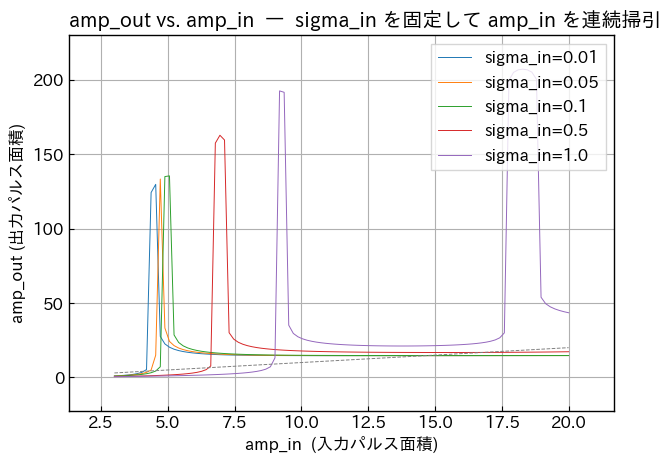

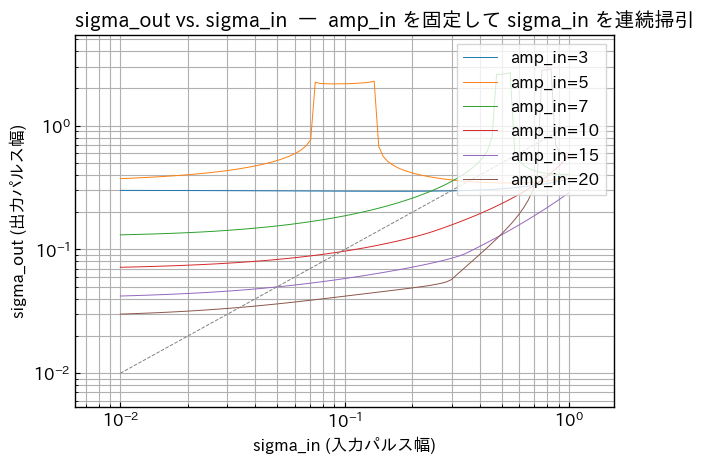

In [ ]:
# ==============================================================
# 依存ライブラリ
#   • numpy, matplotlib, scipy が読み込まれている前提
#   • fre_single, node, J, eta, delta が既に定義されている前提
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


# ──────────────────────────────────────────────────────────────
# シミュレーション関数
# ──────────────────────────────────────────────────────────────
def simulate_pulse(amp_in, sigma_in):
    """
    入力ガウスパルス (面積 = amp_in, 幅 = sigma_in) を与えたときの
    出力応答 y(t) から (amp_out, sigma_out) を返す.
    parameterおよび初期値 (node) はグローバル変数として定義されている前提.
    """
    # 時間窓：パルスの ±5σ と 10 s の余裕
    t0 = -5.0 * sigma_in
    t1 =  5.0 * sigma_in + 10.0

    # 入力電流（面積 amp_in に正規化）
    i_ext = lambda t: amp_in * np.exp(-(t / sigma_in) ** 2) / (
        np.sqrt(2.0 * np.pi) * sigma_in
    )

    # 数値積分
    sol = solve_ivp(
        fre_single, (t0, t1), node,
        args=(J, eta, delta, i_ext),
        rtol=1e-15, atol=1e-15, method
    )

    # ベースライン補正
    baseline = node[0]
    y = sol.y[0] - baseline

    # ガウス成分（正の部分）のみでモーメント計算
    mask = y > 0.0
    if not np.any(mask):                       # 応答がほぼ無い場合
        return np.nan, np.nan

    amp_out = np.trapz(y[mask], sol.t[mask]) * J          # 面積
    t0_out  = np.trapz(sol.t[mask] * y[mask], sol.t[mask]) / amp_out
    var     = np.trapz(((sol.t[mask] - t0_out) ** 2) * y[mask],
                       sol.t[mask]) / amp_out
    sigma_out = np.sqrt(2.0 * var)

    return amp_out, sigma_out


# ──────────────────────────────────────────────────────────────
# 1) sigma_in を固定して amp_in を連続掃引 → amp_out を観測
# ──────────────────────────────────────────────────────────────
sigma_fixed_levels = [0.01, 0.05, 0.10, 0.50, 1.0]  # 曲線ごとに固定する σ_in
amp_scan = np.linspace(3.0, 20.0, 100)              # 連続的に掃引する amp_in

plt.figure()
for sigma_in_val in sigma_fixed_levels:
    amp_out_vals = []
    for amp_in_val in amp_scan:
        amp_out_val, _ = simulate_pulse(amp_in_val, sigma_in_val)
        amp_out_vals.append(amp_out_val)
    plt.plot(amp_scan, amp_out_vals, label=f"sigma_in={sigma_in_val}")
plt.plot(amp_scan, amp_scan, ls="--", color="gray")  # 1:1 線
plt.xlabel("amp_in  (入力パルス面積)")
plt.ylabel("amp_out (出力パルス面積)")
plt.title("amp_out vs. amp_in  —  sigma_in を固定して amp_in を連続掃引")
plt.grid(True)
plt.legend()
plt.tight_layout()


# ──────────────────────────────────────────────────────────────
# 2) amp_in を固定して sigma_in を連続掃引 → sigma_out を観測
# ──────────────────────────────────────────────────────────────
amp_fixed_levels   = [3, 5, 7, 10, 15, 20]          # 曲線ごとに固定する amp_in
sigma_scan = np.logspace(np.log10(0.01), np.log10(1.0), 100)  # 連続的に掃引

plt.figure()
for amp_in_val in amp_fixed_levels:
    sigma_out_vals = []
    for sigma_in_val in sigma_scan:
        _, sigma_out_val = simulate_pulse(amp_in_val, sigma_in_val)
        sigma_out_vals.append(sigma_out_val)
    plt.plot(sigma_scan, sigma_out_vals, label=f"amp_in={amp_in_val}")
plt.plot(sigma_scan, sigma_scan, ls="--", color="gray")  # 1:1 線
plt.xscale("log")        # 幅のレンジが広いので対数軸が見やすい
plt.yscale("log")        
plt.xlabel("sigma_in (入力パルス幅)")
plt.ylabel("sigma_out (出力パルス幅)")
plt.title("sigma_out vs. sigma_in  —  amp_in を固定して sigma_in を連続掃引")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()

plt.show()


In [ ]:
# plot phase plane
plt.scatter(*focus, c = 'k', label = 'focus')
plt.scatter(*node, c = 'k', label = 'node')
plt.scatter(*saddle, c = 'w', edgecolor = 'k', label = 'saddle')

w, v = eig(fre_single_jacobian(0, saddle, J, eta, delta))
v_m = v[:, w<0].flatten() # eigenvalue < 0
v_p = v[:, w>0].flatten() # eigenvalue > 0
sol1 = solve_ivp(fre_single, (t0, t1), saddle + v_p * 1e-5, args = (J, eta, delta), t_eval=t_eval)
sol2 = solve_ivp(fre_single, (t0, t1), saddle - v_p * 1e-5, args = (J, eta, delta), t_eval=t_eval)
sol3 = solve_ivp(fre_single_inverse, (t0, t1), saddle + v_m * 1e-5, args = (J, eta, delta), t_eval=t_eval)
sol4 = solve_ivp(fre_single_inverse, (t0, t1), saddle - v_m * 1e-5, args = (J, eta, delta), t_eval=t_eval)

for i, sol in enumerate([sol1, sol2, sol3, sol4]):
    plt.plot(sol.y[0], sol.y[1], c = 'k')
    if i <= 1:
        idx = np.argmax(np.abs(sol.y[0] - saddle[0]) > 0.1)
    else:
        idx = np.argmax(np.abs(sol.y[0] - saddle[0]) > 0.2)
    r, v = sol.y[:, idx]
    dr, dv = fre_single(sol.t[idx], [r, v], J, eta, delta)
    plt.quiver(r, v, dr, dv, angles = 'xy')
# fill basin of attraction
r_fill = np.append(sol3.y[0], sol4.y[0][::-1]) # XXX : なんで[::-1]が必要なのかは十分に理解しているわけではない...
v_fill = np.append(sol3.y[1], sol4.y[1][::-1])
plt.fill(r_fill, v_fill, alpha = 0.3, c = 'gray')


In [ ]:
amp_in_all = np.linspace(0.1, 20, 100)
amp_out = np.zeros_like(amp_in_all)
sigma_out = np.zeros_like(amp_in_all)
for i, amp_in in enumerate(amp_in_all):
    amp_out[i], sigma_out[i] = simulate_pulse(amp_in, 0.01)

plt.plot(amp_in_all, amp_out)
plt.plot(amp_in_all, amp_in_all, ls = '--')
plt.xlabel("amp_in")
plt.ylabel("amp_out")
plt.xlim(0, 20)
plt.title("amp_out vs amp_in")
plt.show()


plt.plot(amp_in_all, sigma_out)
plt.xlabel("amp_in")
plt.ylabel("sigma_out")
plt.xlim(0, 20)
plt.title("sigma_out vs amp_in")
plt.show()